# Plot the histograms given a folder of location pickles

In [12]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [13]:
%cd /content/gdrive/MyDrive/grapes_project/samples/uvas

/content/gdrive/MyDrive/grapes_project/samples/uvas


In [14]:
from google.colab.patches import cv2_imshow
import cv2
import pandas as pd
import os
import numpy as np
import json
from heat_map_generation.count_heatMap import *
from heat_map_generation.start_end_pts import *

In [15]:
def location_pickle_to_df(file_dir):
    #get the hilera id
    file_name = os.path.basename(os.path.normpath(file_dir))
    _, campo_id, cuartel_id, hilera_id, ampm = os.path.splitext(file_name)[0].split("_")

    #Read the pickle as dict
    df = pd.read_pickle(file_dir)
    
    #Transform to pickle to dataframe
    df = pd.DataFrame(df.items(), columns=['id_racimo', 'info_racimo'])
    df['hilera_id'] = hilera_id
    df['campo_id'] = campo_id
    df['cuartel_id'] = cuartel_id
    df['am_pm'] = ampm

    #Split the info racimo and concat in a new data frame
    tmp = pd.DataFrame(df['info_racimo'].tolist(), index=df.index, columns=['frame_count','x_center','distance'])
    df = pd.concat([df,tmp],axis=1)
    
    return df

In [16]:
def plot_histogram(num_bins, accu_counts, campo_id, cuartel_id, hilera_id):

  x = [i for i in range(num_bins)]

  fig, ax = plt.subplots()

  #color map and norm definition
  cmap = plt.cm.get_cmap('hot', 256)

  # the histogram of the data
  containers = ax.bar(x,accu_counts, edgecolor = 'black')

  # scale values to interval [0,1]
  col = accu_counts / TOP_BOUNDARY_COUNT

  # apply color according to the number of detections
  for c, p in zip(col, containers):
      plt.setp(p, 'facecolor', cmap(c))

  ax.set_xlabel('Sectores de la Hilera')
  ax.set_ylabel('Number of Detections')
  ax.set_title(f'Histogram of Number of Detection per Sectors \n Campo: {campo_id} Cuartel: {cuartel_id} Hilera: {hilera_id}')

  # Tweak spacing to prevent clipping of ylabel
  fig.tight_layout()
  if SAVE_FIGS: plt.savefig(os.path.join(OUTPUT_DIR, "Hilera_{}_{}_{}_histogram.jpg".format(campo_id, cuartel_id, hilera_id)))
  plt.show()


In [17]:
def create_full_data_frame(directory):
  """
  Create a full dataframe. The directory must point to a folder that contains folders divided by cuartel
  """
  # Order the dataframes from a directory in a full dataframe
  data_frames = []
  for folder_name in os.listdir(directory):

      cuartel_folder = os.path.join(directory,folder_name)
      #print("[INFO] Folder name: ", cuartel_folder)

      for file_name in os.listdir(cuartel_folder):

        file_dir = os.path.join(cuartel_folder,file_name)
        #print("[INFO] Pickle name: ", file_dir)
        df_l = location_pickle_to_df(file_dir)

        data_frames.append(df_l)
  return pd.concat(data_frames)

In [18]:
def get_counts_per_segment(n_intervals,hilera_df, hilera_id):
    """
      This function helpes us to calculate the number of detections (counts)
      per segment in a hilera. If there are am and pm cases of the same hilera.
      The detection are added (inverting pm cases if it is necesarry).
      If only there is one (am or pm) then the counts are calculated
      just for that one.
    """
    # Variable to accumulate the number of detections per interval (or segment)
    # in the hilera
    accu_counts = np.zeros(n_intervals)

    # Loop per am_pm
    groups_by_am_pm = hilera_df.groupby(['am_pm'])
    for ampm, _ in groups_by_am_pm:
      ampm_df = groups_by_am_pm.get_group(ampm)

      #print("[INFO] Counting -> hilera_id: {}, am_pm: {}".format(key,ampm))     
      frames = np.array(ampm_df['frame_count'])

      start_frame = np.amin(frames)
      end_frame = np.amax(frames)

      frame_bins = create_frame_intervals(start_frame,end_frame,n_intervals)

      counts,_ = np.histogram(frames,bins=frame_bins)
      
      # When is pm reverse the detection counts list to take into consideration 
      # the orientation of the video
      # If both am and pm have the same orientation, remove this part
      if ampm == "2": counts = np.flipud(counts)
        
      accu_counts += counts

    return accu_counts

In [19]:
def get_n_interval(hilera_id, hilera_pts):
  pt1, pt2 = hilera_pts[int(hilera_id)][0], hilera_pts[int(hilera_id)][1]
  n_intervals, _, _ = segment_hilera(pt1,pt2,DELTA_H)

  return n_intervals

In [20]:
def process_hilera_points(campo_id, cuartel_id):
  """
  Get the start and end points per hilera, in a specific campo_id and cuartel_id

  returns:
    dictionary with key: hilera_id and value: (start_point, end_point)
  """
  # Information of the polygon of the quarter
  poly_info = COORDENADAS_POLY[campo_id][cuartel_id]
  polygon_verts = poly_info["poly_verts"]
  polygon_diagonal = poly_info["diagonal"]
  angle = poly_info["hilera_angulo"]
  n_hileras = poly_info["n_hileras"]

  # Segment the diagonal line of the polygon
  # Return: list of points [(x1,y1)] of the segmented line
  # [star_point] + points + [end_point]
  pts_diagonal = split(*polygon_diagonal, n_hileras+1)

  # Find the starting and ending points of each row in the polygon
  start_points, end_points = find_polygon_divisions(pts_diagonal, polygon_verts, angle)

  # The max and min id of the rows are extracted.
  hileras_ids = [int(x) for x in group['hilera_id'].unique()]
  print(hileras_ids)
  hilera_max = max(hileras_ids)
  hilera_min = min(hileras_ids)
  print(hilera_min,hilera_max)

  # The start and end points are assigned to each individual row
  hilera_pts = {}
  for hilera_idx in hileras_ids:
      hilera_pts[hilera_idx] = (
          start_points[hilera_idx-1], end_points[hilera_idx-1])
      
  return hilera_pts

In [21]:
!ls stuff/pickles/dCyT_pcomplete_aug/location_pickles/

cuartel_3_6


{'2': {'1': {'poly_verts': [[[212, 47], [91, 174], [477, 525]], [[212, 47], [424, 47], [477, 525]]], 'diagonal': [[212, 47], [477, 525]], 'hilera_angulo': 0, 'n_hileras': 5}, '2': {'poly_verts': [[[445, 47], [507, 564], [578, 616], [600, 616]], [[445, 47], [747, 51], [596, 572], [600, 616]]], 'diagonal': [[445, 47], [600, 616]], 'hilera_angulo': 0, 'n_hileras': 10}, '3': {'poly_verts': [[[771, 52], [614, 564], [632, 624], [772, 655], [965, 661]], [[771, 52], [1133, 55], [965, 661]]], 'diagonal': [[771, 52], [965, 661]], 'hilera_angulo': 0, 'n_hileras': 15}}, '1': {'1': {'poly_verts': [[[541, 73], [417, 91], [414, 448]], [[541, 73], [540, 451], [414, 448]]], 'diagonal': [[541, 73], [414, 448]], 'hilera_angulo': 0, 'n_hileras': 70}, '2': {'poly_verts': [[[546, 69], [547, 451], [679, 450]], [[546, 69], [581, 70], [677, 90], [679, 450]]], 'diagonal': [[546, 69], [679, 450]], 'hilera_angulo': 0, 'n_hileras': 75}, '3': {'poly_verts': [[[685, 95], [688, 451], [819, 451]], [[685, 95], [818, 12

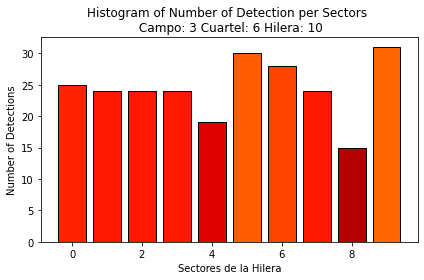

[INFO]: Plot of Campo: 3, Cuartel: 6, Hilera: 16


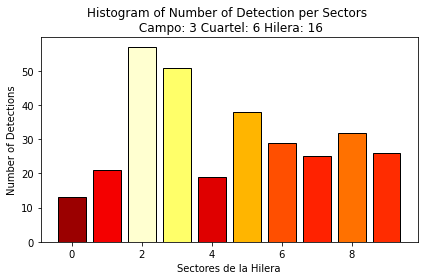

[INFO]: Plot of Campo: 3, Cuartel: 6, Hilera: 20


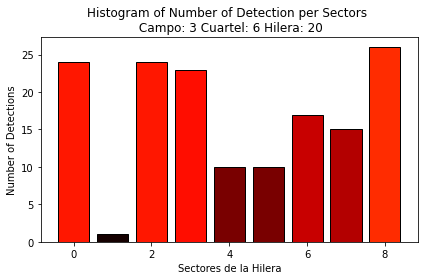

[INFO]: Plot of Campo: 3, Cuartel: 6, Hilera: 21


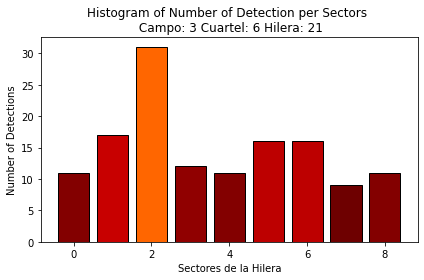

[INFO]: Plot of Campo: 3, Cuartel: 6, Hilera: 26


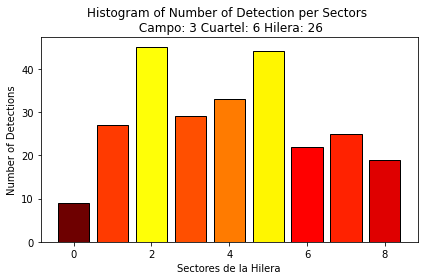

[INFO]: Plot of Campo: 3, Cuartel: 6, Hilera: 37


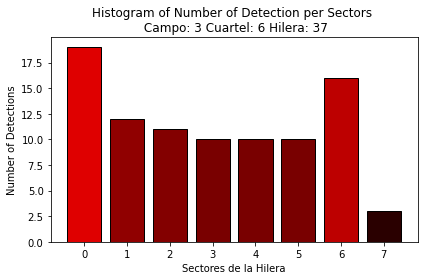

[INFO]: Plot of Campo: 3, Cuartel: 6, Hilera: 5


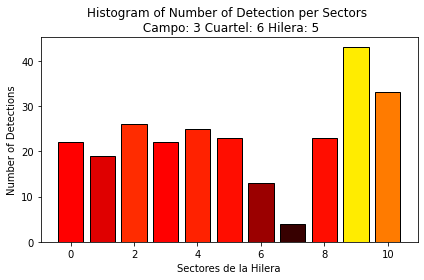

[INFO]: Plot of Campo: 3, Cuartel: 6, Hilera: 6


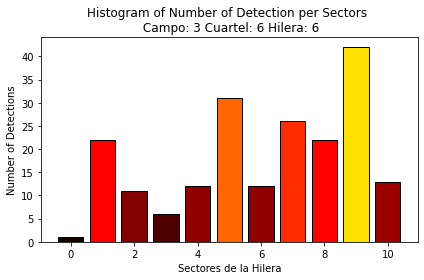

[INFO]: Plot of Campo: 3, Cuartel: 6, Hilera: 7


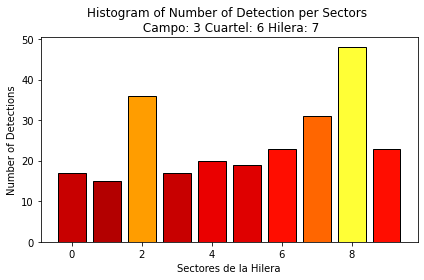

[INFO]: Plot of Campo: 3, Cuartel: 6, Hilera: 9


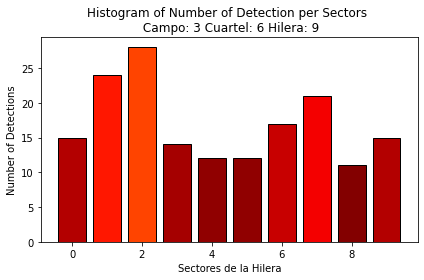

In [22]:
#PICKLES_DIR = "stuff/pickles/dcomplete_pgrapes_aug/location_pickles/campo2"
#PICKLES_DIR = "stuff/pickles/dcompleto_pgrapes/location_pickles/"
PICKLES_DIR = "stuff/pickles/dCyT_pcomplete_aug/location_pickles/"
OUTPUT_DIR = "stuff/histograms/dCyT_pcomplete_aug/"
SAVE_FIGS = True

SAT_INFO = "stuff/json/ConchayToro.json"
json_file = open(SAT_INFO, 'rt')
COORDENADAS_POLY = json.load(json_file)
print(COORDENADAS_POLY)
DELTA_H = 20
TOP_BOUNDARY_COUNT = 60

if not os.path.exists(OUTPUT_DIR):
  os.makedirs(OUTPUT_DIR)

#Create the full data frame
full_df = create_full_data_frame(PICKLES_DIR)

#Loop per campo_id and cuartel_id
groups = full_df.groupby(['campo_id','cuartel_id'])
for key, _ in groups:
  group = groups.get_group(key) 

  #Get the start and end points per hilera
  hilera_pts = process_hilera_points(*key)

  #Loop per each hilera_id
  groups_by_hilera = group.groupby(['hilera_id'])
  for hilera_id, _ in groups_by_hilera:
    hilera_df = groups_by_hilera.get_group(hilera_id)

    # Get the n_interval per hilera_id
    n_intervals = get_n_interval(hilera_id, hilera_pts)

    # Get the number of counts per segment
    accu_counts = get_counts_per_segment(n_intervals, hilera_df, hilera_id)

    #if first == True:
    #Plot the histogram
    info = {
        "campo_id" : key[0],
        "cuartel_id" : key[1],
        "hilera_id" : hilera_id
    }
    print("[INFO]: Plot of Campo: {}, Cuartel: {}, Hilera: {}".format(*info.values()))
    plot_histogram(n_intervals, accu_counts, **info)    